In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import xgboost as xgb
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.ticker as mtick
from scipy.stats import mode
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
#-----------------
!pip install gdown #needed to read CSV from Drive
#----------------

In [2]:
# ID sharing file googledrive
file_id = "17cDYSw3MB7C1CLVRMML_BFKlMSICznp3"

# dowload file
!gdown $file_id -O /content/DataFraudCard.csv

# read file
DataFraud = pd.read_csv("/content/DataFraudCard.csv")

# Control dataframe
print(DataFraud.head())

# Clone before transformation
DataFraud_raw = DataFraud.copy()




DataFraud['gender'] = DataFraud['gender'].map({'F': 0, 'M': 1})
DataFraud['dob'] = pd.to_datetime(DataFraud['dob'])
DataFraud['age'] = datetime.now().year - DataFraud['dob'].dt.year
label = LabelEncoder()
DataFraud['category'] = label.fit_transform(DataFraud['category'])

R = 6371
def haversine_vec(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1.0 - a))
    return R * c

DataFraud['distance_km'] = haversine_vec(
    DataFraud['lat'], DataFraud['long'],
    DataFraud['merch_lat'], DataFraud['merch_long']
)


DataFraud['trans_date_trans_time'] = pd.to_datetime(DataFraud['trans_date_trans_time'])
DataFraud['trans_hour'] = DataFraud['trans_date_trans_time'].dt.hour
DataFraud['trans_weekday'] = DataFraud['trans_date_trans_time'].dt.weekday
DataFraud['trans_date'] = DataFraud['trans_date_trans_time'].dt.date
DataFraud['trans_count_24h'] = DataFraud.groupby(['cc_num', 'trans_date'])['trans_num'].transform('count')
customer_avg_amt = DataFraud.groupby('cc_num')['amt'].mean()
customer_std_amt = DataFraud.groupby('cc_num')['amt'].std()
DataFraud['amt_z_score'] = (DataFraud['amt'] - DataFraud['cc_num'].map(customer_avg_amt)) / DataFraud['cc_num'].map(customer_std_amt)
customer_avg_distance = DataFraud.groupby('cc_num')['distance_km'].mean()
customer_std_distance = DataFraud.groupby('cc_num')['distance_km'].std()
DataFraud['distance_z_score'] = (DataFraud['distance_km'] - DataFraud['cc_num'].map(customer_avg_distance)) / DataFraud['cc_num'].map(customer_std_distance)
customer_max_distance = DataFraud.groupby('cc_num')['distance_km'].max()
DataFraud['distance_ratio_to_max'] = DataFraud['distance_km'] / DataFraud['cc_num'].map(customer_max_distance)
customer_avg_hour = DataFraud.groupby('cc_num')['trans_hour'].mean()
DataFraud['hour_deviation'] = abs(DataFraud['trans_hour'] - DataFraud['cc_num'].map(customer_avg_hour))
customer_mode_weekday = DataFraud.groupby('cc_num')['trans_weekday'].agg(lambda x: x.mode()[0] if not x.empty else 0)
DataFraud['unusual_weekday'] = (DataFraud['trans_weekday'] != DataFraud['cc_num'].map(customer_mode_weekday)).astype(int)
customer_top_category = DataFraud.groupby('cc_num')['category'].agg(lambda x: x.mode()[0] if not x.empty else 0)
DataFraud['unusual_category'] = (DataFraud['category'] != DataFraud['cc_num'].map(customer_top_category)).astype(int)
DataFraud['amt_z_score'] = DataFraud['amt_z_score'].fillna(0).replace([np.inf, -np.inf], [10, -10])
DataFraud['distance_z_score'] = DataFraud['distance_z_score'].fillna(0)
DataFraud['distance_ratio_to_max'] = DataFraud['distance_ratio_to_max'].fillna(1.0)

print(DataFraud.head)


Downloading...
From (original): https://drive.google.com/uc?id=17cDYSw3MB7C1CLVRMML_BFKlMSICznp3
From (redirected): https://drive.google.com/uc?id=17cDYSw3MB7C1CLVRMML_BFKlMSICznp3&confirm=t&uuid=92ed41a6-84f9-4a8a-9d47-93173a6e1bfb
To: /content/DataFraudCard.csv
100% 208M/208M [00:02<00:00, 95.4MB/s]
   Unnamed: 0 trans_date_trans_time            cc_num       category     amt  \
0           0   2019-01-01 00:00:18  2703186189652095       misc_net    4.97   
1           1   2019-01-01 00:00:44      630423337322    grocery_pos  107.23   
2           2   2019-01-01 00:00:51    38859492057661  entertainment  220.11   
3           3   2019-01-01 00:01:16  3534093764340240  gas_transport   45.00   
4           4   2019-01-01 00:03:06   375534208663984       misc_pos   41.96   

  gender      lat      long         dob                         trans_num  \
0      F  36.0788  -81.1781  1988-03-09  0b242abb623afc578575680df30655b9   
1      F  48.8878 -118.2105  1978-06-21  1f76529f8574734946361

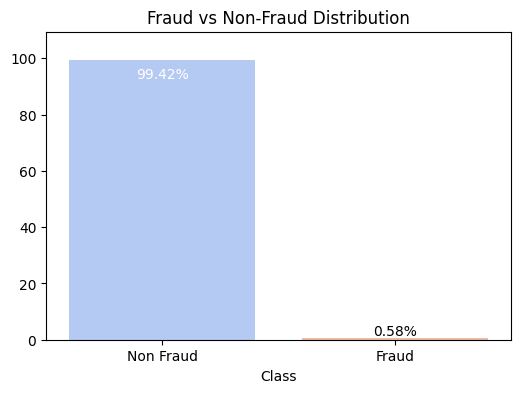

In [3]:


fraud_percent = DataFraud['is_fraud'].value_counts(normalize=True) * 100
df = pd.DataFrame({
    'Class': ['Non Fraud', 'Fraud'],
    'Percentage': fraud_percent.values
})
plt.figure(figsize=(6,4))
ax = sns.barplot(data=df, x='Class', y='Percentage', hue='Class', palette='coolwarm', dodge=False, legend=False)
plt.ylabel('')
plt.title('Fraud vs Non-Fraud Distribution')

for i, value in enumerate(df['Percentage']):
    if value > 90:
        plt.text(i, value - 5, f"{value:.2f}%", ha='center', va='center', color='white', fontsize=10)
    else:
        plt.text(i, value + 1, f"{value:.2f}%", ha='center', fontsize=10)

plt.ylim(0, max(df['Percentage']) + 10)
plt.show()

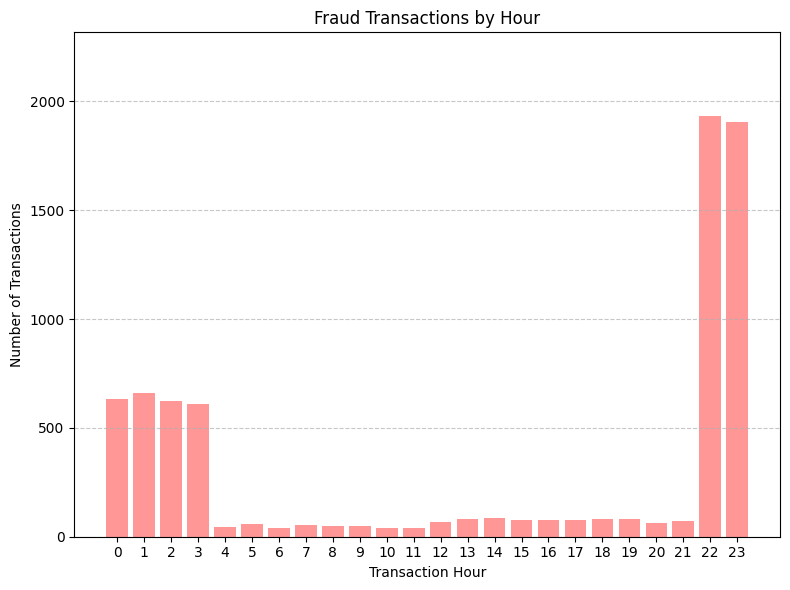

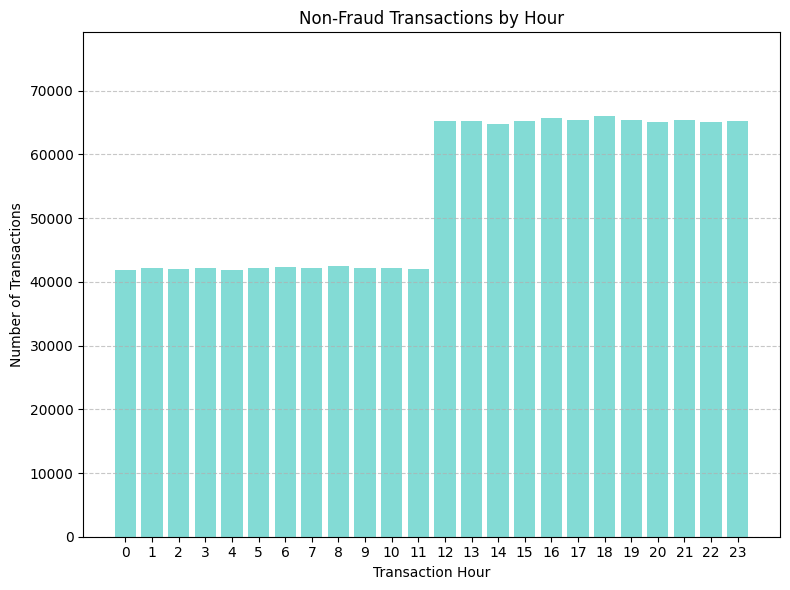

In [4]:
# Extracting data for fraud transactions
visual_fraud = DataFraud[DataFraud['is_fraud'] == 1]

# Count of transactions per hour (fraud only)
visual_fraud_hour = visual_fraud['trans_hour'].value_counts().sort_index()

# X-axis indices and labels (hours 0 to 23)
visual_ind = visual_fraud_hour.index.tolist()
visual_all_hours = list(range(24))

# Y-axis zoom (20% above the maximum value)
max_visual_fraud = visual_fraud_hour.max()
visual_y_limit = max_visual_fraud * 1.2

# Plot fraud
plt.figure(figsize=(8,6))
plt.bar(visual_ind, visual_fraud_hour, color='#FF6B6B', alpha=0.7)
plt.title('Fraud Transactions by Hour')
plt.xlabel('Transaction Hour')
plt.ylabel('Number of Transactions')
plt.xticks(visual_all_hours)
plt.ylim(0, visual_y_limit)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Extracting data for non-fraud transactions
visual_nonfraud = DataFraud[DataFraud['is_fraud'] == 0]

# Count of transactions per hour (non-fraud only)
visual_nonfraud_hour = visual_nonfraud['trans_hour'].value_counts().sort_index()

# X-axis indices and labels (hours 0 to 23)
visual_nonfraud_ind = visual_nonfraud_hour.index.tolist()
visual_all_hours = list(range(24))

# Y-axis zoom (20% above the maximum value)
max_visual_nonfraud = visual_nonfraud_hour.max()
visual_nonfraud_y_limit = max_visual_nonfraud * 1.2

# Plot non fraud
plt.figure(figsize=(8,6))
plt.bar(visual_nonfraud_ind, visual_nonfraud_hour, color='#4ECDC4', alpha=0.7)
plt.title('Non-Fraud Transactions by Hour')
plt.xlabel('Transaction Hour')
plt.ylabel('Number of Transactions')
plt.xticks(visual_all_hours)
plt.ylim(0, visual_nonfraud_y_limit)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

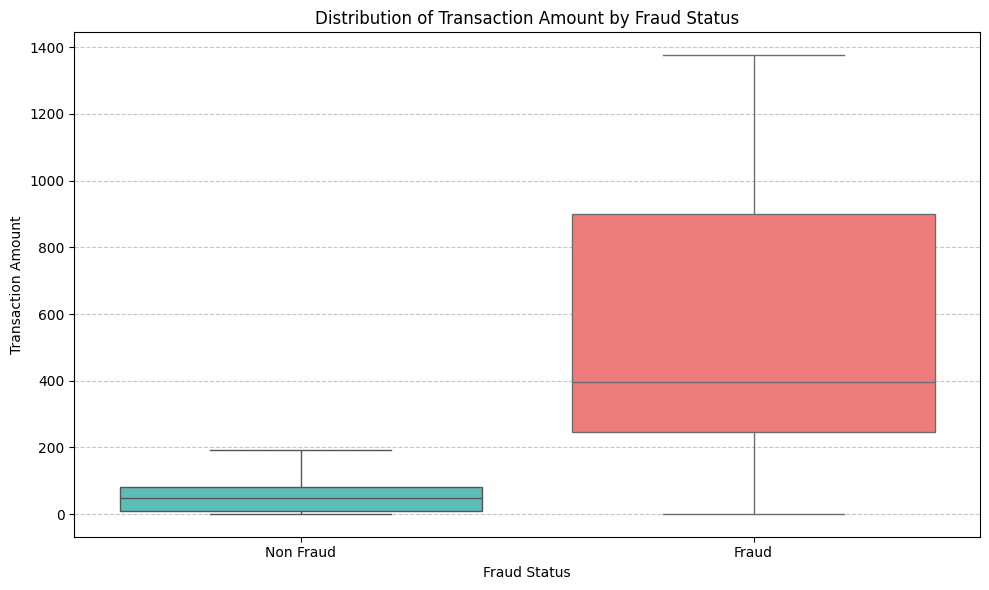

In [5]:
visual_amount = DataFraud[['is_fraud', 'amt']].copy()

plt.figure(figsize=(10, 6))

colors = ['#4ECDC4', '#FF6B6B']  # colors Non Fraud, Fraud

# Map is_fraud
visual_amount['fraud_label'] = visual_amount['is_fraud'].map({0: 'Non Fraud', 1: 'Fraud'})


for i, label in enumerate(['Non Fraud', 'Fraud']):
    sns.boxplot(
        x=visual_amount.loc[visual_amount['fraud_label'] == label, 'fraud_label'],
        y=visual_amount.loc[visual_amount['fraud_label'] == label, 'amt'],
        showfliers=False,
        color=colors[i]
    )

plt.title('Distribution of Transaction Amount by Fraud Status')
plt.xlabel('Fraud Status')
plt.ylabel('Transaction Amount')


plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0f}'))

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

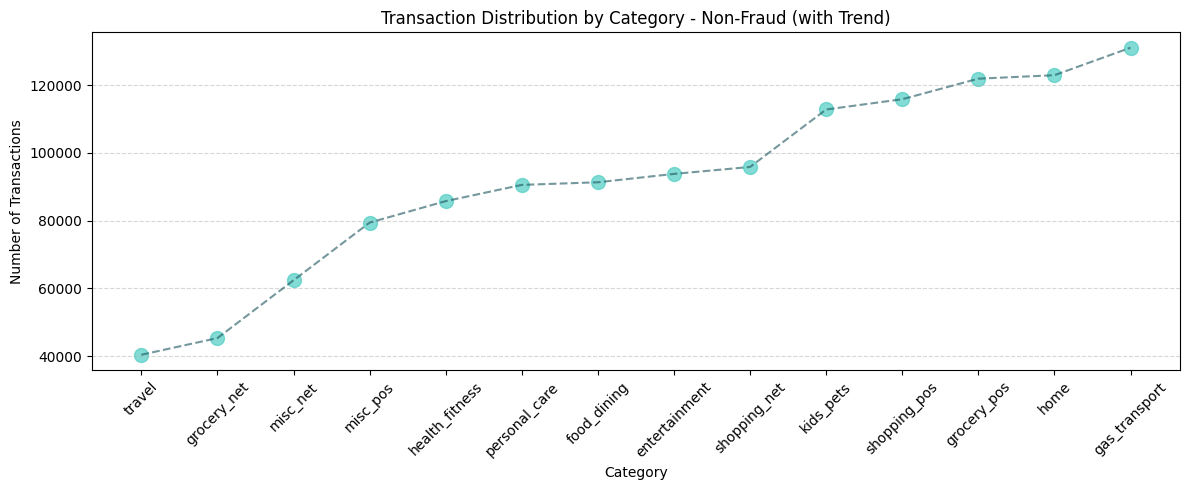

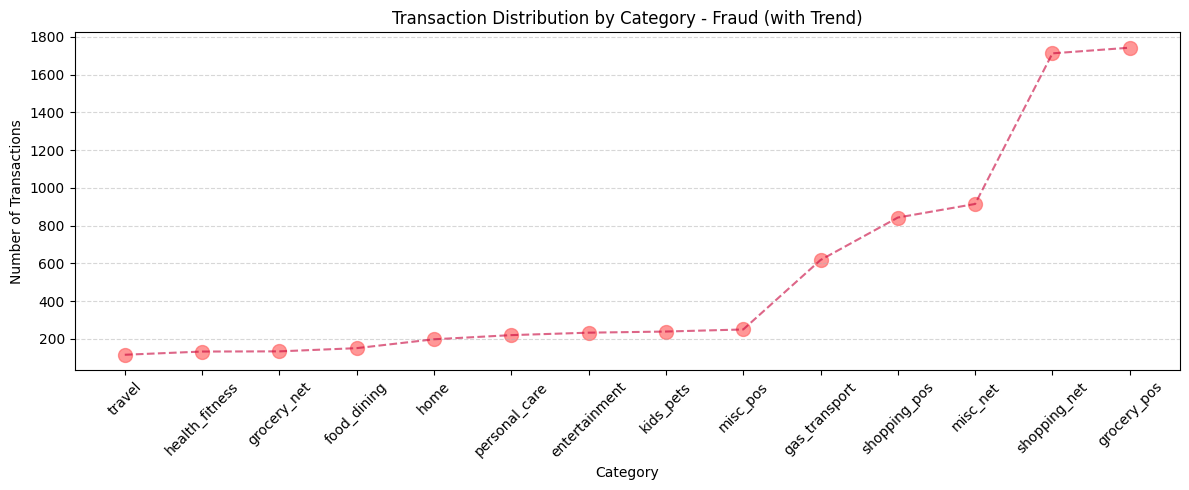

In [6]:



# Count transactions per category and type
category_count_raw = DataFraud_raw.groupby(['category', 'is_fraud']).size().reset_index(name='count')

# Separate Non-Fraud and Fraud, sort by count ascending
non_fraud = category_count_raw[category_count_raw['is_fraud']==0].sort_values(by='count')
fraud = category_count_raw[category_count_raw['is_fraud']==1].sort_values(by='count')

# Scatter for Non-Fraud with trend line
plt.figure(figsize=(12,5))
plt.scatter(
    x=non_fraud['category'],
    y=non_fraud['count'],
    s=100,
    color='#4ECDC4',
    alpha=0.7,
    label='Non-Fraud'
)
plt.plot(
    non_fraud['category'],
    non_fraud['count'],
    color='#1A535C',
    linestyle='--',
    alpha=0.6
)
plt.xticks(rotation=45)
plt.ylabel("Number of Transactions")
plt.xlabel("Category")
plt.title("Transaction Distribution by Category - Non-Fraud (with Trend)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Scatter for Fraud with trend line
plt.figure(figsize=(12,5))
plt.scatter(
    x=fraud['category'],
    y=fraud['count'],
    s=100,
    color='#FF6B6B',
    alpha=0.7,
    label='Fraud'
)
plt.plot(
    fraud['category'],
    fraud['count'],
    color='#C70039',
    linestyle='--',
    alpha=0.6
)
plt.xticks(rotation=45)
plt.ylabel("Number of Transactions")
plt.xlabel("Category")
plt.title("Transaction Distribution by Category - Fraud (with Trend)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




In [7]:

cols_to_keep = [
    'gender', 'age', 'is_fraud', 'category', 'distance_km',
    'trans_hour', 'trans_weekday', 'trans_count_24h','distance_z_score','amt_z_score', 'distance_ratio_to_max',
    'hour_deviation', 'unusual_weekday', 'unusual_category']

DataFraud = DataFraud[cols_to_keep]

features_to_scale = ['distance_km', 'trans_count_24h', 'amt_z_score','distance_z_score', 'hour_deviation']

#separation x feature ----- y targhet
X_Container = DataFraud.drop('is_fraud', axis=1)
y_Container = DataFraud['is_fraud']

#Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_Container, y_Container, test_size=0.3, random_state=421)
# for debug
X_train_temp = X_train.copy()
X_test_temp = X_test.copy()

#scaling
scaler = StandardScaler()
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

print("Data after scaler:")
print(X_train.head())

Data after scaler:
         gender  age  category  distance_km  trans_hour  trans_weekday  \
751426        1   32         0     0.995668          16              6   
489517        0   28         2     0.360591           7              4   
503435        0   68         1     0.759343          13              1   
1224065       0   36         2    -1.132135           7              1   
1113202       1   51         0    -0.031250          19              1   

         trans_count_24h  distance_z_score  amt_z_score  \
751426         -0.937286          1.041806    -0.201725   
489517         -0.311802          0.306791     0.151824   
503435         -1.250029          0.797594    -0.506308   
1224065         0.313683         -1.004399    -0.068493   
1113202        -0.624544          0.037645    -0.321734   

         distance_ratio_to_max  hour_deviation  unusual_weekday  \
751426                0.771520       -0.504767                1   
489517                0.607383        0.657848 

In [8]:
print("Distribution before SMOTE:")
print(np.bincount(y_train))
smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("Distribution after SMOTE:")
print(np.bincount(y_train))

Distribution before SMOTE:
[902450   5222]
Distribution after SMOTE:
[902450 270735]


In [9]:

model = xgb.XGBClassifier(
    tree_method='hist',       # Uses histogram-based algorithm, fast for large datasets
    device='cuda',            # Train on GPU
    eval_metric='logloss',    # Evaluation metric: log-loss for probabilistic classification
    verbosity=2,              # Show detailed logs during training
    random_state=42,          # Seed for reproducibility
    max_depth=7,              # Maximum tree depth
    n_estimators=1000,        # Maximum number of trees
    learning_rate=0.05,       # Step size shrinkage (learning rate)
    subsample=0.8,            # Fraction of samples for each tree (reduces overfitting)
    colsample_bytree=0.8,     # Fraction of features for each tree (reduces overfitting)
    gamma=0,                  # Minimum loss reduction required to make a split
    min_child_weight=1,       # Minimum sum of instance weight needed in a child
    reg_alpha=0,              # L1 regularization term on weights
    reg_lambda=1              # L2 regularization term on weights
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]


[08:17:32] INFO: /workspace/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1173185, 13, 15251405).
[08:17:33] INFO: /workspace/src/data/ellpack_page.cu:167: Ellpack is dense.


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [08:17:41] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


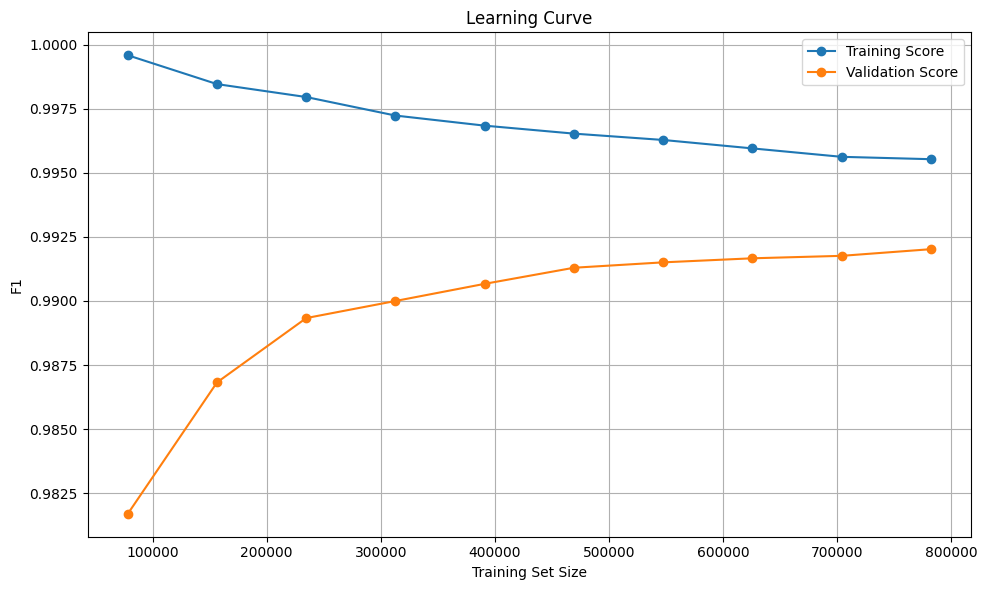

In [10]:
# Learning Curve
def plot_learning_curve(estimator, X, y, scoring='f1', cv=3):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y,
        cv=cv,
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Validation Score')
    plt.title('Learning Curve')
    plt.xlabel('Training Set Size')
    plt.ylabel(scoring.upper())
    plt.legend(loc='best')
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_learning_curve(model, X_train, y_train, scoring='f1', cv=3)

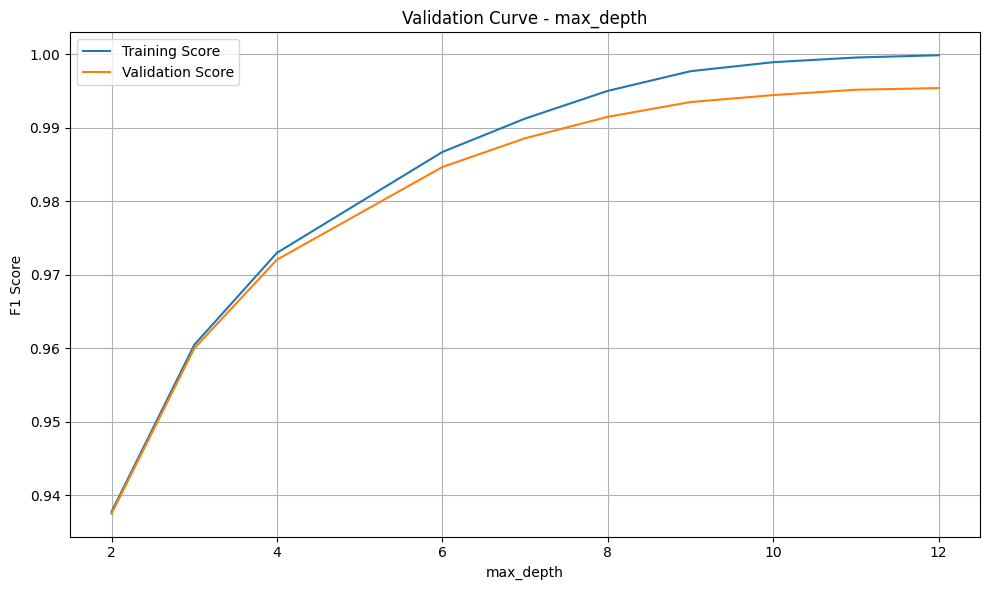

In [11]:
param_range = [2, 3, 4,6,7,8,9,10,11,12]

train_scores, test_scores = validation_curve(
    xgb.XGBClassifier(tree_method='hist', device='cuda', eval_metric='logloss', random_state=42),
    X_train, y_train,
    param_name='max_depth',
    param_range=param_range,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_scores_mean, label='Training Score')
plt.plot(param_range, test_scores_mean, label='Validation Score')
plt.title('Validation Curve - max_depth')
plt.xlabel('max_depth')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.grid()
plt.tight_layout()
plt.show()

In [12]:

thresholds_to_test = [0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9]
results = []

for threshold in thresholds_to_test:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold)

    results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

threshold_results = pd.DataFrame(results)
threshold_results = threshold_results.sort_values(by='Precision', ascending=False)
print("\n=== Results for each threshold value ===")
print(threshold_results.to_string(index=False))



=== Results for each threshold value ===
 Threshold  Precision   Recall  F1-Score
       0.9   0.969494 0.695709  0.810094
       0.8   0.939394 0.732925  0.823414
       0.7   0.905307 0.761821  0.827389
       0.6   0.862868 0.782399  0.820666
       0.5   0.815954 0.801664  0.808746
       0.3   0.662746 0.838879  0.740483
       0.2   0.540268 0.866462  0.665546


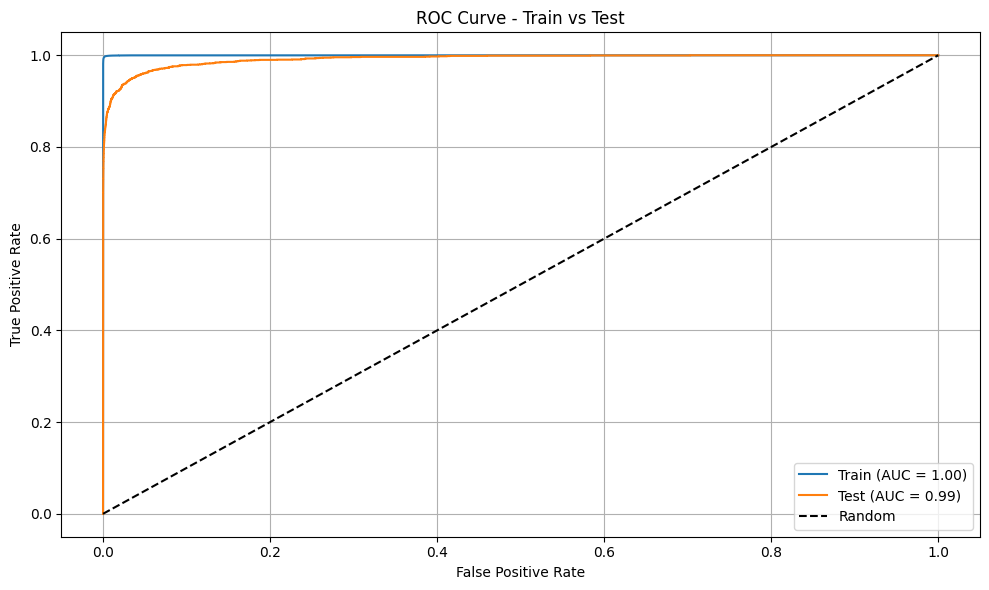

In [13]:

# Plot ROC train vs test
def plot_roc_curve(y_true, y_score, dataset_label):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{dataset_label} (AUC = {roc_auc:.2f})')

y_train_proba = model.predict_proba(X_train)[:, 1]

plt.figure(figsize=(10, 6))
plot_roc_curve(y_train, y_train_proba, 'Train')
plot_roc_curve(y_test, y_pred_proba, 'Test')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('ROC Curve - Train vs Test')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:

y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_pred_proba)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


# Metrics 0
precision_0 = precision_score(y_test, y_pred, pos_label=0)
recall_0 = recall_score(y_test, y_pred, pos_label=0)
f1_0 = f1_score(y_test, y_pred, pos_label=0)

# Metrics 1
precision_1 = precision_score(y_test, y_pred, pos_label=1)
recall_1 = recall_score(y_test, y_pred, pos_label=1)
f1_1 = f1_score(y_test, y_pred, pos_label=1)

#  (average)
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

#DataFrame
metrics_table = pd.DataFrame({
    'Precision': [precision_0, precision_1, precision_macro, precision_weighted],
    'Recall': [recall_0, recall_1, recall_macro, recall_weighted],
    'F1-Score': [f1_0, f1_1, f1_macro, f1_weighted]
}, index=['Class 0', 'Class 1', 'Macro Avg', 'Weighted Avg'])

print("\n--- Detailed classification metrics ---")
print(metrics_table)


print("\n=== GAP Performance Train vs Test ===")
print(f"Accuracy Gap : {train_accuracy - test_accuracy:.4f}")
print(f"F1-score Gap : {train_f1 - test_f1:.4f}")
print(f"AUC Gap      : {train_auc - test_auc:.4f}")

# Training AUC
train_auc = roc_auc_score(y_train, y_train_proba)
# Test AUC
test_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


--- Detailed classification metrics ---
              Precision    Recall  F1-Score
Class 0        0.998829  0.998932  0.998880
Class 1        0.815954  0.801664  0.808746
Macro Avg      0.907391  0.900298  0.903813
Weighted Avg   0.997755  0.997774  0.997764

=== GAP Performance Train vs Test ===
Accuracy Gap : 0.0001
F1-score Gap : 0.1867
AUC Gap      : 0.0080
Train AUC: 1.0000
Test AUC: 0.9920


<Figure size 1200x800 with 0 Axes>

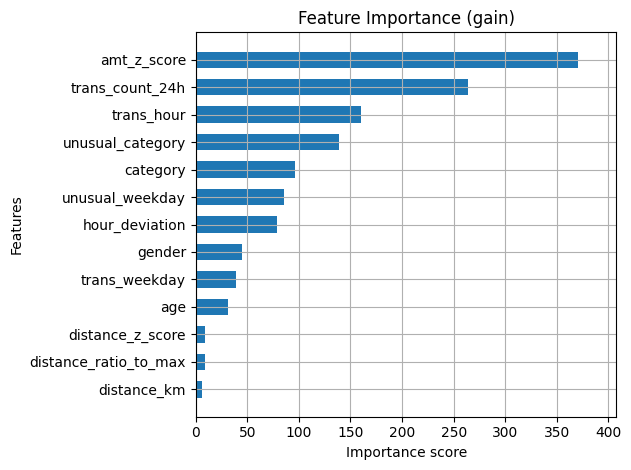

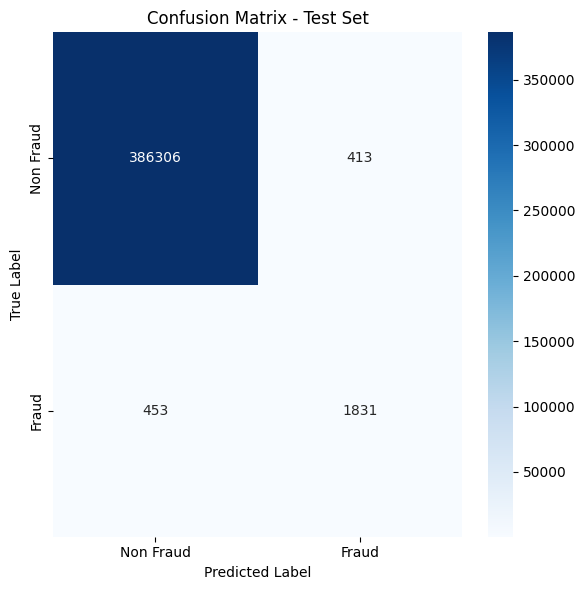

In [15]:

plt.figure(figsize=(12, 8))
xgb.plot_importance(model, importance_type='gain', max_num_features=15, height=0.6, show_values=False)
plt.title('Feature Importance (gain)')
plt.tight_layout()
plt.show()


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non Fraud', 'Fraud'],
            yticklabels=['Non Fraud', 'Fraud'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()